<h1 align='center'><u><font color ='pickle'>Sentiment Analysis on IMDB dataset</u></h1></font>


# <font color ='pickle'>**Notebook Overview**
* Till now we have learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* So now lets use all those technique and create a classification pipeline for it.
* We will create 3 pipelines:
    1. Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model pipeline
    2. Feature Engineering + ML Model pipeline
    3. Feature Engineering + Data Preprocessing + Sparse Embeddings(TF-IDF) + ML Model pipeline.

# <font color ='pickle'>**Installing/Importing libraries**

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -U spacy

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import textwrap as tw
import matplotlib.pyplot as plt

# save and load models
import joblib

import re

#from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from  sklearn.compose import ColumnTransformer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_folder = Path('/content/drive/MyDrive/data')
#base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/data')

In [6]:
data_folder = base_folder/'datasets/aclImdb'
model_folder = base_folder/'models/nlp_fall_2022/imdb'
custom_functions = base_folder/'custom-functions'

In [ ]:
!python -m spacy download 'en_core_web_sm'

In [8]:
import sys
sys.path.append(str(custom_functions))

In [9]:
import custom_preprocessor as cp
from  featurizer import ManualFeatures
from  plot_learning_curve import plot_learning_curve

# <font color ='pickle'>**Load dataset**

For this notebook, we will use IMDB movie review dataset. <br>
LInk for complete dataset: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz.

We downloaded the dataset in the previous lecture (notebook: 10_Faster_tokenization_spacy_final.ipynb)

We will now use the saved train.csv and test.csv file.

In [10]:
# location of train and test files
train_file = data_folder /'train.csv'
test_file = data_folder / 'test.csv'

In [11]:
# creating Pandas Dataframe
train_data = pd.read_csv(train_file, index_col=0)
test_data = pd.read_csv(test_file, index_col=0)

In [12]:
# print shape of the datasets
print(f'Shape of Training data set is : {train_data.shape}')
print(f'Shape of Test data set is : {test_data.shape}')

Shape of Training data set is : (25000, 2)
Shape of Test data set is : (25000, 2)


In [13]:
#Printing top 5 train records
train_data.head()

,Reviews,Labels
0,Ever wanted to know just how much Hollywood co...,1
1,The movie itself was ok for the kids. But I go...,1
2,You could stage a version of Charles Dickens' ...,1
3,this was a fantastic episode. i saw a clip fro...,1
4,and laugh out loud funny in many scenes.<br />...,1


In [14]:
#Printing top 5 test records
test_data.head()

,Reviews,Labels
0,THE SEA INSIDE a film by Alejandro Amenabar.<b...,1
1,After World War II the ungoing crime in Phenix...,1
2,"""Pitch Black"" was a complete shock to me when ...",1
3,This film is an excellent teaching tool as a p...,1
4,"Sweet, rich valley girl develops crush on a pu...",1


# <font color ='pickle'>**Create Subset of Data**

In [15]:
train_smaller = train_data.sample(frac=0.1, replace=True, random_state=1)

In [16]:
test_smaller = test_data.sample(frac=0.1, replace=True, random_state=1)

# <font color ='pickle'>**Exploratory Data Analysis**

In [17]:
# Printing basic info
train_smaller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 235 to 21762
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Reviews  2500 non-null   object
 1   Labels   2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 58.6+ KB


In [18]:
# Checking distribution of class labels for train dataset
train_smaller['Labels'].value_counts()

1    1286
0    1214
Name: Labels, dtype: int64

In [19]:
# Checking distribution of class labels for test dataset
test_smaller['Labels'].value_counts()

1    1286
0    1214
Name: Labels, dtype: int64

As we can see our data is well balannced.

# <font color ='pickle'>**Classification Pipeline**

## <font color ='pickle'>**PreProcessing**

In [20]:
X_train, X_test, y_train, y_test = train_smaller['Reviews'].values, test_smaller['Reviews'].values, train_smaller['Labels'].values, test_smaller['Labels'].values

print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (2500,) y_train: (2500,)
X_test: (2500,) y_test: (2500,)


In [22]:
cp.SpacyPreprocessor??

In [21]:
X_train_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_train)

In [23]:
# save  this to a file
X_train_cleaned_sparse_embed = data_folder / 'x_train_cleaned_sparse_embed.pkl'

In [24]:
joblib.dump(X_train_cleaned, X_train_cleaned_sparse_embed)

['/content/drive/MyDrive/data/datasets/aclImdb/x_train_cleaned_sparse_embed.pkl']

In [25]:
X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_test)

In [26]:
# save  this to a file
X_test_cleaned_sparse_embed = data_folder / 'x_test_cleaned_sparse_embed.pkl'

In [27]:
joblib.dump(X_test_cleaned, X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/data/datasets/aclImdb/x_test_cleaned_sparse_embed.pkl']

## <font color ='pickle'>**Pipeline 1: Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model**

###<font color ='pickle'>**Create Pipeline**

In [28]:
classifier_1a = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                         ('classifier', LogisticRegression(max_iter = 10000)),
                        ])

### <font color ='pickle'>**Parameter Grid**

In [29]:
# We have used default valus for all parameters except for lammetizer
# Ideally we can specify range of values for all parameters
# If the search space is very large then we should use RandomSerachCV

param_grid_classifier_1a = {'vectorizer__max_features': [100, 500, 1000, 2000, 5000],
                           
                           'classifier__C': [ 0.1, 1, 10, 100, 100000]}

### <font color ='pickle'>**Apply GridSearch**

In [30]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_1a = GridSearchCV(estimator=classifier_1a, param_grid=param_grid_classifier_1a, cv = 3)

In [31]:
# Fit the model on training data
X_trained_cleaned = joblib.load(X_train_cleaned_sparse_embed)
grid_classifier_1a.fit(X_trained_cleaned, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(token_pattern='[\\S]+')),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 100000],
                         'vectorizer__max_features': [100, 500, 1000, 2000,
                                                      5000]})

In [32]:
print(f'Best cross-validation score: {grid_classifier_1a.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_1a.best_params_)
print("\nBest estimator: ", grid_classifier_1a.best_estimator_)

Best cross-validation score: 0.86

Best parameters:  {'classifier__C': 10, 'vectorizer__max_features': 5000}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=5000, token_pattern='[\\S]+')),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])


### <font color ='pickle'>**Save Model**

In [33]:
file_model_sparse_embed = model_folder / 'sparse_embed_model.pkl'

In [34]:
joblib.dump(grid_classifier_1a.best_estimator_, file_model_sparse_embed)

['/content/drive/MyDrive/data/models/nlp_fall_2022/imdb/sparse_embed_model.pkl']

### <font color ='pickle'>**Load Model**

In [35]:
# load the saved model
loaded_model_sparse_embed = joblib.load(file_model_sparse_embed)

### <font color ='pickle'>**Plot Learning Curve**

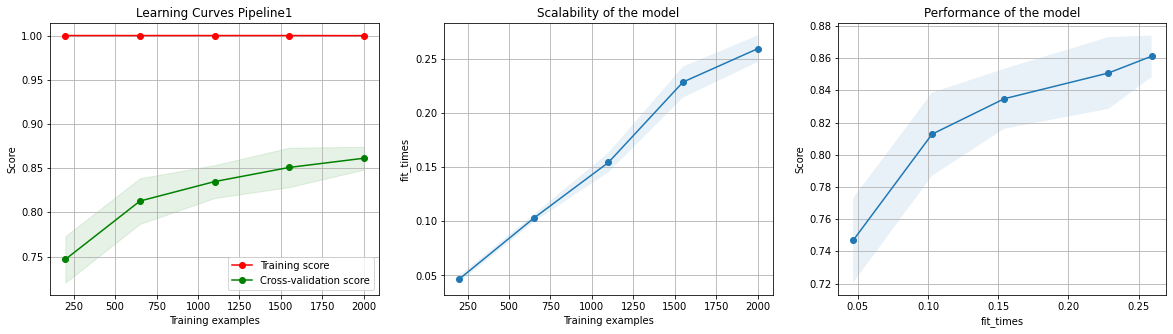

In [36]:
# plot learning curces
# This cell can take upto 30 minutes to run
plot_learning_curve(loaded_model_sparse_embed, 'Learning Curves Pipeline1', X_train_cleaned, y_train)
plt.show()

<font color ='indianred'>**Observations**</font>
<br>
Clearly there is <font color ='indianred'>**overfitting**</font>. In case of overfitting we can improve results by 

1. Adding more data (training model on complete dataset)
2. By hyperparameter tuning (reduce model complexity) of logistic regression and vectorizer.


In [37]:
# Accuracy on Train data set
grid_classifier_sparse_embed = loaded_model_sparse_embed.score(X_train_cleaned, y_train)
print(f'Accuracy on train set  is {grid_classifier_sparse_embed}')

Accuracy on train set  is 0.9996


###<font color ='pickle'>**Evaluate model on test datset**

In [40]:
# Final Pipeline
def final_pipeline(text):
  # cleaned_text = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(text)
  cleaned_text = joblib.load(X_test_cleaned_sparse_embed)
  predictions = loaded_model_sparse_embed.predict(cleaned_text)
  return predictions

In [41]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

### <font color ='pickle'>**Classification report for test dataset**

* As we have already seen, our dataset is well balanced. Hence we have used accuracy as our scoring method.
* However, it is a good idea to also look at classification report which gives precision, recall, and f1-score for both labels and average score also.
* This metric works very well in case of balanced as well as imbalanced data because it lets you measure the performance of model for each labels.

In [42]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1214
           1       0.85      0.86      0.85      1286

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



## <font color ='pickle'>**Pipeline 2: Data Preprocessing + Manual Features + ML Model pipeline**

In this case we will extract following features and use these as the input to our logistic regression.
  1. number of words
  2. number of characters
  3. number of characters without space
  4. average word length
  5. number of digits
  6. number of numbers
  7. number of nouns or propernouns
  8. number of aux
  9. number of verbs
  10. number of adjectives
  11. number of ner (entiites)

### <font color ='pickle'>**Generate Manual Features**

In [46]:
ManualFeatures??

In [43]:
featurizer =  ManualFeatures(spacy_model='en_core_web_sm')

In [44]:
X_train_features, feature_names  = featurizer.fit_transform(X_train)

In [45]:
X_train_features[0:3]

array([[6.46000000e+02, 3.32900000e+03, 2.68400000e+03, 4.15479876e+00,
        0.00000000e+00, 0.00000000e+00, 2.30000000e+01, 1.48000000e+02,
        5.10000000e+01, 8.10000000e+01, 4.90000000e+01],
       [1.72000000e+02, 9.50000000e+02, 7.79000000e+02, 4.52906977e+00,
        4.00000000e+00, 3.00000000e+00, 1.20000000e+01, 4.50000000e+01,
        7.00000000e+00, 2.00000000e+01, 1.50000000e+01],
       [3.51000000e+02, 2.08400000e+03, 1.73400000e+03, 4.94017094e+00,
        0.00000000e+00, 0.00000000e+00, 1.60000000e+01, 8.70000000e+01,
        1.80000000e+01, 4.20000000e+01, 4.30000000e+01]])

In [47]:
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_digits',
 'count_numbers',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner']

### <font color ='pickle'>**Create Pipeline**

In [48]:
classifier_1b = Pipeline([('classifier', LogisticRegression(max_iter = 10000)),
                        ])

### <font color ='pickle'>**Parameter Grid**

In [49]:
# We have used default valus for all parameters except for lammetizer
# Ideally we can specify range of values for all parameters
# If the search space is very large then we should use RandomSerachCV

param_grid_classifier_1b = {'classifier__C': [0.01, 10, 1000, 100000]}

###<font color ='pickle'>**Apply GridSearch**

In [50]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_1b = GridSearchCV(estimator=classifier_1b, param_grid=param_grid_classifier_1b, cv = 3)

In [52]:
# Fit the model on training data
grid_classifier_1b.fit(X_train_features, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.01, 10, 1000, 100000]})

In [53]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1b.best_score_))
print("\nBest parameters: ", grid_classifier_1b.best_params_)
print("\nBest estimator: ", grid_classifier_1b.best_estimator_)

Best cross-validation score: 0.62

Best parameters:  {'classifier__C': 0.01}

Best estimator:  Pipeline(steps=[('classifier', LogisticRegression(C=0.01, max_iter=10000))])


### <font color ='pickle'>**Save Model**

In [54]:
file_model_features = model_folder / 'features_model.pkl'

In [55]:
joblib.dump(grid_classifier_1b.best_estimator_, file_model_features)

['/content/drive/MyDrive/data/models/nlp_fall_2022/imdb/features_model.pkl']

### <font color ='pickle'>**Load Model**

In [56]:
# load the saved model
loaded_final_model_features = joblib.load(file_model_features)

### <font color ='pickle'>**Plot Learning Curve**

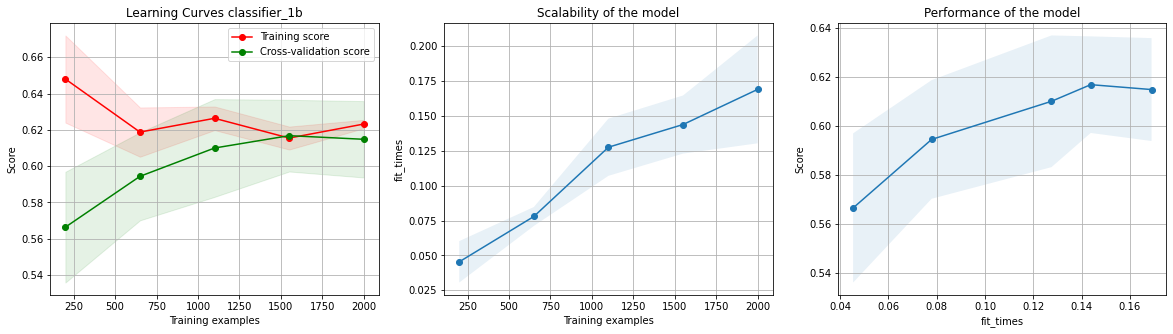

In [57]:
# plot learning curces
# This cell can take upto 30 minutes to run
plot_learning_curve(loaded_final_model_features, 'Learning Curves classifier_1b', X_train_features, y_train)
plt.show()

<font color ='indianred'>**Observations** </font>
<br>
Clearly there is <font color ='indianred'> **underfitting** </font>. In case of underfitting we can improve results by 

1. By hyperparameter tuning (increase model complexity) of logistic regression.
2. Add New features or Polynomial terms

In [58]:
# Accuracy on Train data set
grid_classifier_sparse_embed = loaded_final_model_features.score(X_train_features, y_train)
print(f'Accuracy on train set  is {grid_classifier_sparse_embed}')

Accuracy on train set  is 0.6276


###<font color ='pickle'>**Evaluate model on test datset**

In [59]:
# Final Pipeline
def final_pipeline(text):
  test_features, feature_names = featurizer.fit_transform(X_test)
  predictions = loaded_final_model_features.predict(test_features)
  return predictions

In [60]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

###<font color ='pickle'>**Classification report for test dataset**

* As we have already seen, our dataset is well balanced. Hence we have used accuracy as our scoring method.
* However, it is a good idea to also look at classification report which gives precision, recall, and f1-score for both labels and average score also.
* This metric works very well in case of balanced as well as imbalanced data because it lets you measure the performance of model for each labels.

In [61]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.60      0.55      0.58      1214
           1       0.61      0.65      0.63      1286

    accuracy                           0.61      2500
   macro avg       0.60      0.60      0.60      2500
weighted avg       0.60      0.61      0.60      2500



## <font color ='pickle'>**Pipeline 3: Combine Manual Features and TfID vectors**

### <font color ='pickle'>**Combine Manual Features and tfidf features**

<font color ='indianred'>**The approach described in this section is generic and can be used to combine any text (e.g. embeddings generated from text data) with non-text related variables**.

In [62]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned, columns =['cleaned_text']), 
                           pd.DataFrame(X_train_features, columns=feature_names)),axis =1)

In [63]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,david mamet direct film fitting story uneven m...,646.0,3329.0,2684.0,4.154799,0.0,0.0,23.0,148.0,51.0,81.0,49.0
1,sensual tough maria braun hanna schygula marry...,172.0,950.0,779.0,4.529070,4.0,3.0,12.0,45.0,7.0,20.0,15.0
2,love hard define feeling young ache inside mal...,351.0,2084.0,1734.0,4.940171,0.0,0.0,16.0,87.0,18.0,42.0,43.0
3,look forward kathryn bigelow movie great antic...,160.0,841.0,682.0,4.262500,1.0,1.0,4.0,29.0,12.0,18.0,14.0
4,great movie reminiscent wonderful disney class...,208.0,1137.0,930.0,4.471154,9.0,5.0,5.0,46.0,23.0,17.0,25.0


In [64]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               2500 non-null   object 
 1   count_words                2500 non-null   float64
 2   count_characters           2500 non-null   float64
 3   count_characters_no_space  2500 non-null   float64
 4   avg_word_length            2500 non-null   float64
 5   count_digits               2500 non-null   float64
 6   count_numbers              2500 non-null   float64
 7   noun_count                 2500 non-null   float64
 8   aux_count                  2500 non-null   float64
 9   verb_count                 2500 non-null   float64
 10  adj_count                  2500 non-null   float64
 11  ner                        2500 non-null   float64
dtypes: float64(11), object(1)
memory usage: 234.5+ KB


In [65]:
subset = X_train_final[0:10]

In [66]:
subset.shape

(10, 12)

In [67]:
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix
class SparseTransformer(TransformerMixin, BaseEstimator):
    
  def __init__(self):
    return None

  def fit(self, X, y=None):
      return self

  def transform(self, X, y=None):
      return csr_matrix(X)
 

In [68]:
sparse_features = Pipeline([('sparse', SparseTransformer()),                     
                        ]) 
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)),                     
                        ]) 

In [69]:
sparse_features.fit_transform(subset.iloc[:,1:])

<10x11 sparse matrix of type '<class 'numpy.float64'>'
	with 102 stored elements in Compressed Sparse Row format>

In [70]:
vectorizer.fit_transform(subset.iloc[:,0])

<10x5 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [71]:
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned_text'),
      ], remainder=sparse_features
     )

In [72]:
test = combined_features.fit_transform(subset)

In [73]:
test.dtype

dtype('float64')

###<font color ='pickle'>**Create Final Pipeline**

In [74]:
classifier_1c = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter = 10000)),
                        ])

In [75]:
classifier_1c.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

### <font color ='pickle'>**Parameter Grid**

In [76]:
# We are exploring a small combination of parameters
# If the search space is very large then we should use RandomSerachCV

param_grid_classifier_1c = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000],
                            'classifier__C': [0.1, 1, 10]}

### <font color ='pickle'>**Apply GridSearch**

In [77]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_1c = GridSearchCV(estimator=classifier_1c, param_grid=param_grid_classifier_1c, cv = 3)

In [78]:
# Fit the model on training data
grid_classifier_1c.fit(X_train_final, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('combined_features',
                                        ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                     SparseTransformer())]),
                                                          transformers=[('tfidf',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=5))]),
                                                                         'cleaned_text')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'combined_features__tfidf__tfidf__max_features': [500,
                                               

In [79]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1c.best_score_))
print("\nBest parameters: ", grid_classifier_1c.best_params_)
print("\nBest estimator: ", grid_classifier_1c.best_estimator_)

Best cross-validation score: 0.84

Best parameters:  {'classifier__C': 10, 'combined_features__tfidf__tfidf__max_features': 2000}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=2000))]),
                                                  'cleaned_text')])),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])


### <font color ='pickle'>**Save Model**

In [80]:
file_model_combined = model_folder / 'combined_model.pkl'

In [81]:
joblib.dump(grid_classifier_1c.best_estimator_, file_model_combined)

['/content/drive/MyDrive/data/models/nlp_fall_2022/imdb/combined_model.pkl']

### <font color ='pickle'>**Load Model**

In [82]:
# load the saved model
loaded_model_combined = joblib.load(file_model_combined)

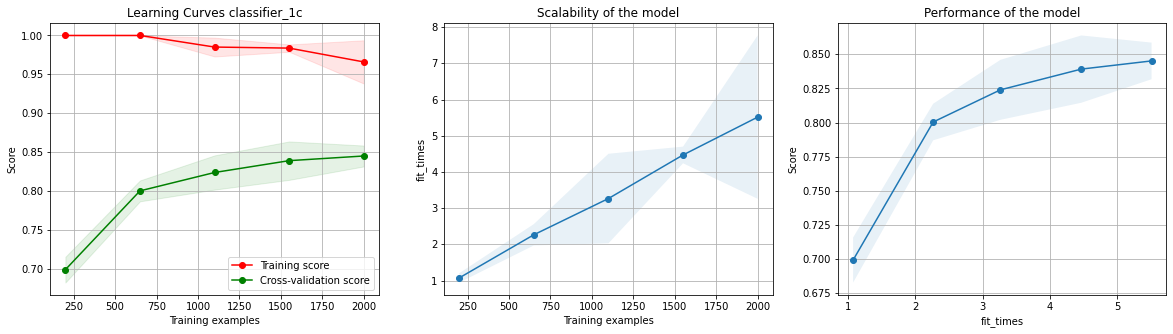

In [84]:
# plot learning curves
plot_learning_curve(loaded_model_combined, 'Learning Curves classifier_1c', X_train_final, y_train)
plt.show()

<font color ='indianred'>**Observations**
<br></font>
Clearly there is <font color ='indianred'>**overfitting**</font>. In case of overfitting we can improve results by 

1. Adding more data (training model on complete dataset)
2. By hyperparameter tuning (reduce model complexity) of logistic regression and vectorizer.

In [ ]:
# Accuracy on Train data set
grid_classifier_combined = loaded_model_combined.score(X_train_final, y_train)
print(f'Accuracy on train set  is {grid_classifier_combined}')

Accuracy on train set  is 0.986


### <font color ='pickle'>**Evaluate model on test datset**

In [ ]:
X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_test)

In [ ]:
# save  this to a file
X_test_cleaned_sparse_embed = model_folder / 'x_test_cleaned_sparse_embed.pkl'

In [ ]:
joblib.dump(X_test_cleaned, X_test_cleaned_sparse_embed)

['/home/harpreet/Insync/harpreet24.utd@gmail.com/teaching_spring_2022/Models/x_test_cleaned_sparse_embed.pkl']

In [85]:
# Final Pipeline
def final_pipeline(text):
  #cleaned_text = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(text)
  cleaned_text = joblib.load(X_test_cleaned_sparse_embed)
  X_features, feature_names  = featurizer.fit_transform(text)
  X_final = pd.concat((pd.DataFrame(cleaned_text, columns =['cleaned_text']), 
                           pd.DataFrame(X_features, columns=feature_names)),axis =1)
  
  predictions = loaded_model_combined.predict(X_final)
  return predictions

In [86]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

### <font color ='pickle'>**Classification report for test dataset**

* As we have already seen, our dataset is well balanced. Hence we have used accuracy as our scoring method.
* However, it is a good idea to also look at classification report which gives precision, recall, and f1-score for both labels and average score also.
* This metric works very well in case of balanced as well as imbalanced data because it lets you measure the performance of model for each labels.

In [87]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1214
           1       0.83      0.86      0.85      1286

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



## <font color ='pickle'>**Another Approach - Stacking**

<font color ='indianred'>**Stacking: Try different models on manual features and different models using tfidf. Use predictions of these modes as new features.**